# **Scotium Yetenek Avcılığı Sınıflandırma**

In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from yellowbrick.cluster import KElbowVisualizer
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier, XGBRegressor

In [36]:
df = pd.read_csv("/kaggle/input/scotium-datasets/scoutium_attributes.csv",sep=';')
df2 = pd.read_csv("/kaggle/input/scotium-datasets/scoutium_potential_labels.csv",sep=';')

df.head()

,task_response_id,match_id,evaluator_id,player_id,position_id,analysis_id,attribute_id,attribute_value
0,4915,62935,177676,1361061,2,12818495,4322,56.0
1,4915,62935,177676,1361061,2,12818495,4323,56.0
2,4915,62935,177676,1361061,2,12818495,4324,67.0
3,4915,62935,177676,1361061,2,12818495,4325,56.0
4,4915,62935,177676,1361061,2,12818495,4326,45.0


In [37]:
df2.head()

,task_response_id,match_id,evaluator_id,player_id,potential_label
0,4915,62935,177676,1361061,average
1,4915,62935,177676,1361626,highlighted
2,4915,62935,177676,1361858,average
3,4915,62935,177676,1362220,highlighted
4,4915,62935,177676,1364951,highlighted


In [38]:
# Veri setlerini birleştirme
dff = pd.merge(df, df2, how='left', on=["task_response_id", 'match_id', 'evaluator_id', "player_id"])
dff.head(50)

,task_response_id,match_id,evaluator_id,player_id,position_id,analysis_id,attribute_id,attribute_value,potential_label
0,4915,62935,177676,1361061,2,12818495,4322,56.0,average
1,4915,62935,177676,1361061,2,12818495,4323,56.0,average
2,4915,62935,177676,1361061,2,12818495,4324,67.0,average
3,4915,62935,177676,1361061,2,12818495,4325,56.0,average
4,4915,62935,177676,1361061,2,12818495,4326,45.0,average
5,4915,62935,177676,1361061,2,12818495,4327,56.0,average
6,4915,62935,177676,1361061,2,12818495,4328,56.0,average
7,4915,62935,177676,1361061,2,12818495,4329,67.0,average
8,4915,62935,177676,1361061,2,12818495,4330,45.0,average
9,4915,62935,177676,1361061,2,12818495,4332,56.0,average


In [39]:
dff.to_csv('merged_data.csv', index=False)

In [40]:
# position_id içerisindeki Kaleci (1) sınıfını veri setinden kaldırınız.

dff = dff[dff["position_id"] != 1]

In [41]:
# potential_label içerisindeki below_average sınıfını veri setinden kaldırınız.
# ( below_average sınıfı tüm verisetinin %1'ini oluşturur)

dff = dff[dff["potential_label"] != "below_average"]

In [42]:
#Adım 1: İndekste “player_id”,“position_id” ve “potential_label”, sütunlarda “attribute_id” 
# ve değerlerde scout’ların oyunculara verdiği puan “attribute_value” olacak şekilde pivot table’ı oluşturunuz.
pt = pd.pivot_table(dff, values="attribute_value", columns="attribute_id", index=["player_id","position_id","potential_label"])


In [43]:
#Adım 2:  İndeksleri değişken olarak atayınız ve “attribute_id” sütunlarının isimlerini stringe çeviriniz
pt = pt.reset_index(drop=False)
pt.columns = pt.columns.map(str)

In [44]:
# Sayısal değişken kolonlarını “num_cols” adıyla bir listeye kaydetmek 
num_cols = pt.columns[3:]

In [45]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())


check_df(pt)


##################### Shape #####################
(271, 37)
##################### Types #####################
attribute_id
player_id            int64
position_id          int64
potential_label     object
4322               float64
4323               float64
4324               float64
4325               float64
4326               float64
4327               float64
4328               float64
4329               float64
4330               float64
4332               float64
4333               float64
4335               float64
4338               float64
4339               float64
4340               float64
4341               float64
4342               float64
4343               float64
4344               float64
4345               float64
4348               float64
4349               float64
4350               float64
4351               float64
4352               float64
4353               float64
4354               float64
4355               float64
4356               float64
4357         

In [46]:
# Kategorik değişkenlerin özeti

def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()

for col in ["position_id","potential_label"]:
    cat_summary(pt, col)

             position_id      Ratio
position_id                        
2                     53  19.557196
6                     41  15.129151
10                    29  10.701107
7                     28  10.332103
3                     26   9.594096
8                     25   9.225092
4                     24   8.856089
5                     23   8.487085
9                     22   8.118081
##########################################
                 potential_label      Ratio
potential_label                            
average                      215  79.335793
highlighted                   56  20.664207
##########################################


count    271.000000
mean      58.367774
std       14.526790
min       23.000000
5%        34.000000
10%       34.000000
20%       45.000000
30%       56.000000
40%       56.000000
50%       56.000000
60%       67.000000
70%       67.000000
80%       67.000000
90%       78.000000
95%       78.000000
99%       78.000000
max       89.000000
Name: 4322, dtype: float64


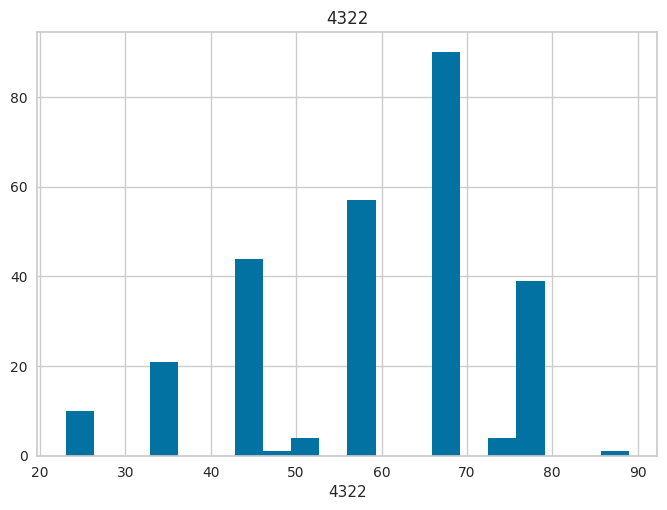

count    271.000000
mean      58.739852
std       14.757096
min       23.000000
5%        34.000000
10%       34.000000
20%       45.000000
30%       45.000000
40%       56.000000
50%       56.000000
60%       67.000000
70%       67.000000
80%       72.500000
90%       78.000000
95%       78.000000
99%       78.000000
max       89.000000
Name: 4323, dtype: float64


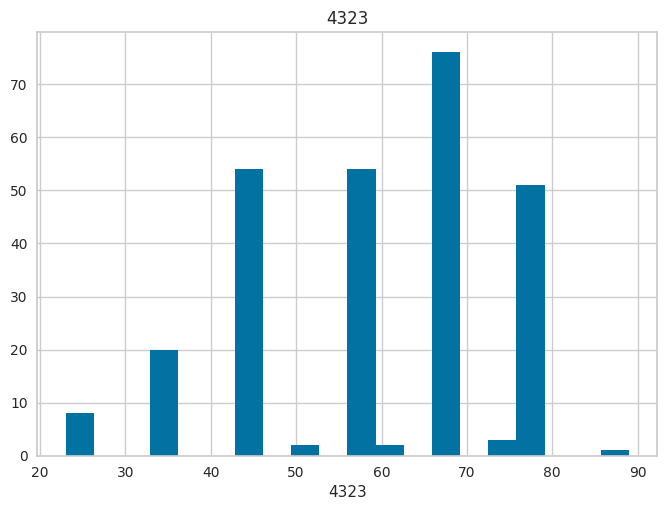

count    271.000000
mean      56.250308
std       15.868485
min       23.000000
5%        34.000000
10%       34.000000
20%       34.000000
30%       45.000000
40%       56.000000
50%       56.000000
60%       67.000000
70%       67.000000
80%       67.000000
90%       78.000000
95%       78.000000
99%       78.000000
max       78.000000
Name: 4324, dtype: float64


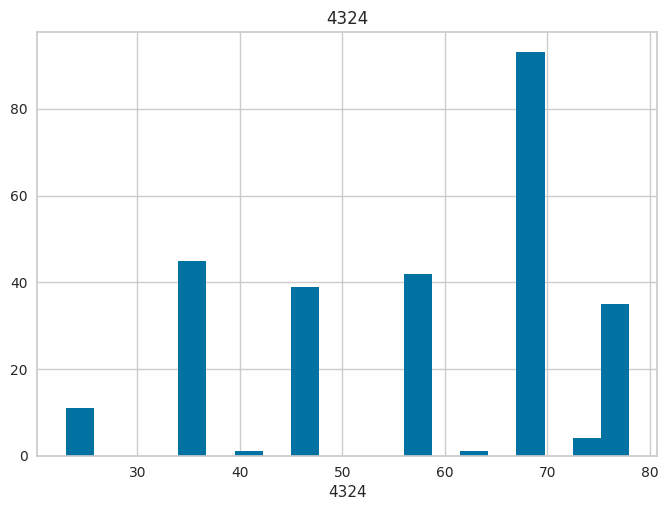

count    271.000000
mean      56.947109
std       14.749474
min       12.000000
5%        34.000000
10%       34.000000
20%       45.000000
30%       45.000000
40%       56.000000
50%       61.500000
60%       67.000000
70%       67.000000
80%       67.000000
90%       78.000000
95%       78.000000
99%       78.000000
max       89.000000
Name: 4325, dtype: float64


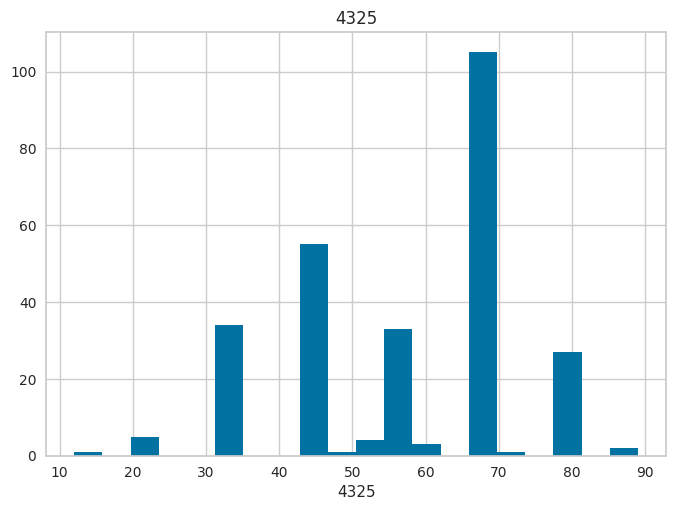

count    271.000000
mean      56.324723
std       14.799953
min       23.000000
5%        34.000000
10%       34.000000
20%       45.000000
30%       45.000000
40%       56.000000
50%       61.500000
60%       67.000000
70%       67.000000
80%       67.000000
90%       67.000000
95%       78.000000
99%       78.000000
max       89.000000
Name: 4326, dtype: float64


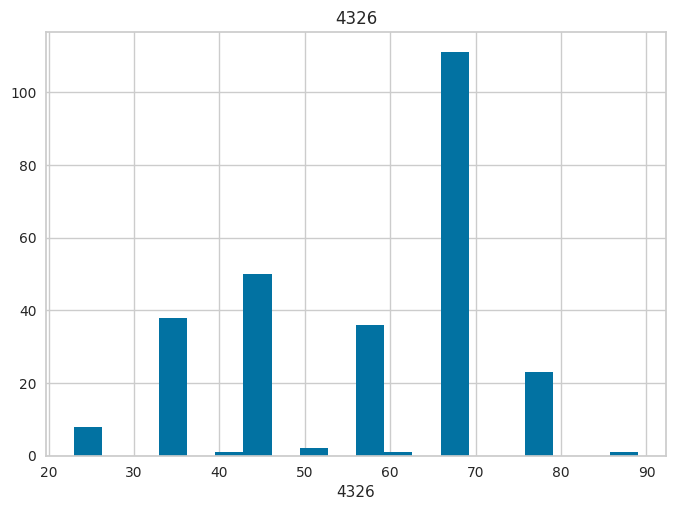

count    271.000000
mean      56.520910
std       14.522141
min       23.000000
5%        34.000000
10%       34.000000
20%       45.000000
30%       45.000000
40%       56.000000
50%       56.000000
60%       67.000000
70%       67.000000
80%       67.000000
90%       78.000000
95%       78.000000
99%       78.000000
max       78.000000
Name: 4327, dtype: float64


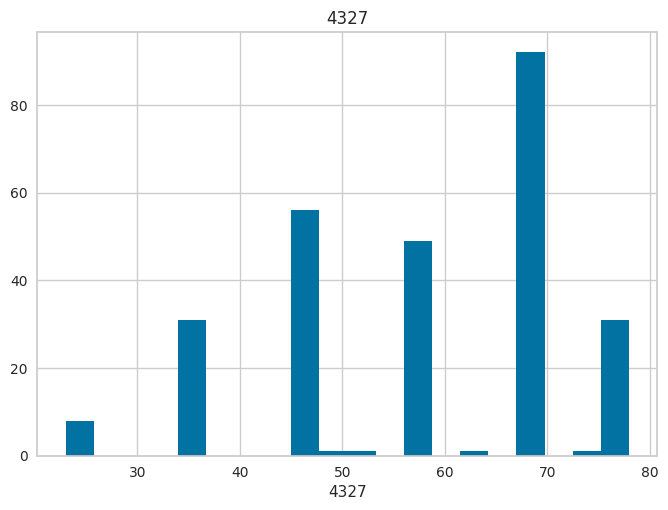

count    271.000000
mean      58.232472
std       14.610607
min       23.000000
5%        34.000000
10%       34.000000
20%       45.000000
30%       45.000000
40%       56.000000
50%       56.000000
60%       67.000000
70%       67.000000
80%       67.000000
90%       78.000000
95%       78.000000
99%       78.000000
max       89.000000
Name: 4328, dtype: float64


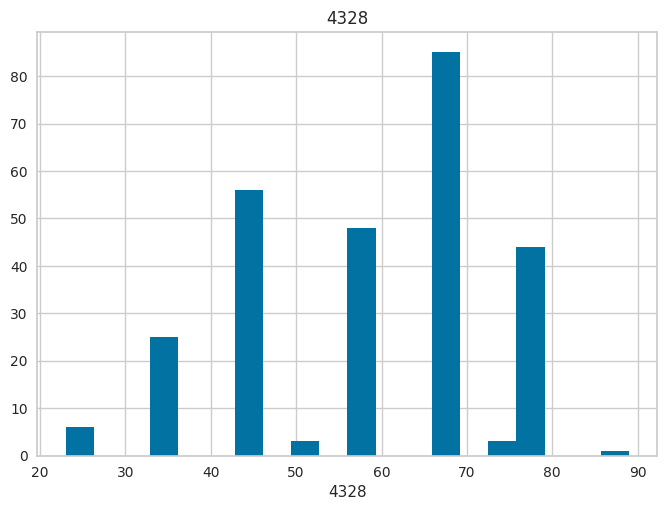

count    271.000000
mean      59.565191
std       18.433611
min       12.000000
5%        23.000000
10%       34.000000
20%       45.000000
30%       45.000000
40%       56.000000
50%       67.000000
60%       67.000000
70%       78.000000
80%       78.000000
90%       78.000000
95%       78.000000
99%       78.000000
max       89.000000
Name: 4329, dtype: float64


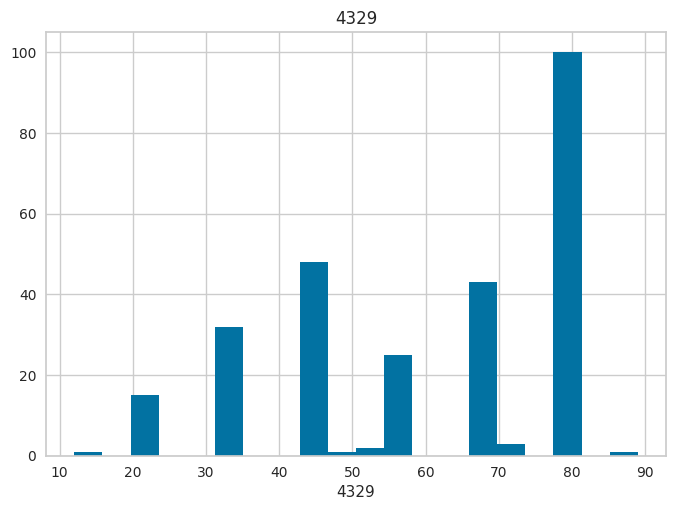

count    271.000000
mean      56.771218
std       14.076815
min       23.000000
5%        34.000000
10%       34.000000
20%       45.000000
30%       56.000000
40%       56.000000
50%       61.500000
60%       67.000000
70%       67.000000
80%       67.000000
90%       67.000000
95%       72.500000
99%       78.000000
max       89.000000
Name: 4330, dtype: float64


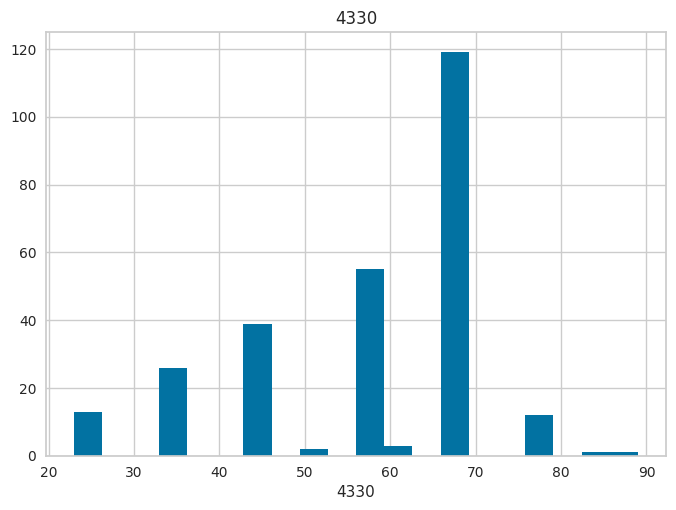

count    271.000000
mean      57.657442
std       13.542010
min       23.000000
5%        34.000000
10%       34.000000
20%       45.000000
30%       56.000000
40%       56.000000
50%       61.500000
60%       67.000000
70%       67.000000
80%       67.000000
90%       67.000000
95%       78.000000
99%       78.000000
max       89.000000
Name: 4332, dtype: float64


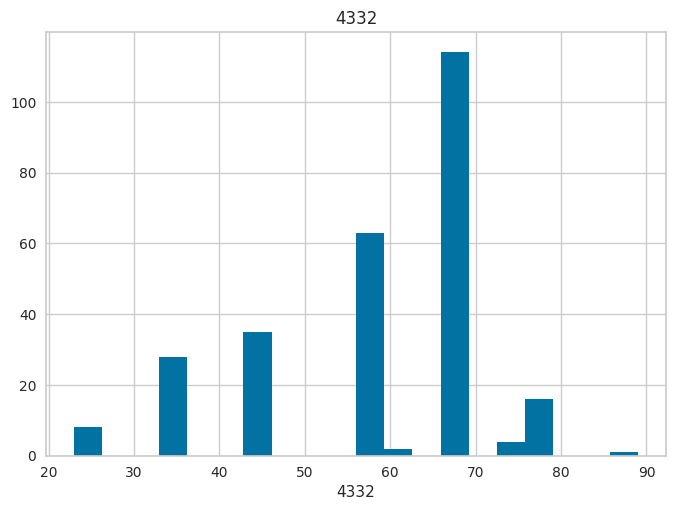

count    271.000000
mean      59.497540
std       16.369983
min       23.000000
5%        34.000000
10%       34.000000
20%       45.000000
30%       56.000000
40%       56.000000
50%       67.000000
60%       67.000000
70%       72.500000
80%       78.000000
90%       78.000000
95%       78.000000
99%       78.000000
max       78.000000
Name: 4333, dtype: float64


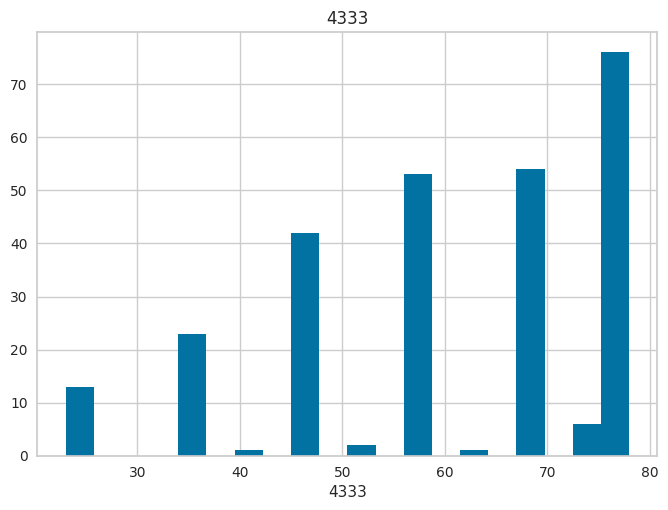

count    271.000000
mean      50.817958
std       16.269353
min       12.000000
5%        23.000000
10%       34.000000
20%       34.000000
30%       34.000000
40%       45.000000
50%       56.000000
60%       56.000000
70%       67.000000
80%       67.000000
90%       67.000000
95%       67.000000
99%       78.000000
max       89.000000
Name: 4335, dtype: float64


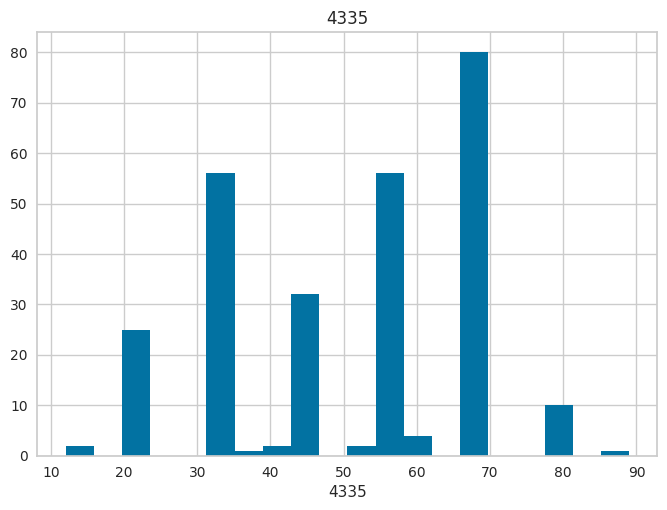

count    271.000000
mean      57.116236
std       15.670577
min       23.000000
5%        34.000000
10%       34.000000
20%       45.000000
30%       45.000000
40%       56.000000
50%       56.000000
60%       67.000000
70%       67.000000
80%       67.000000
90%       78.000000
95%       78.000000
99%       78.000000
max       78.000000
Name: 4338, dtype: float64


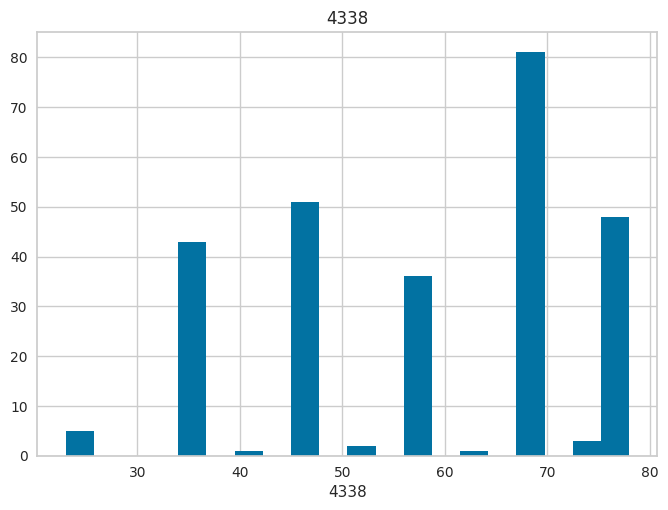

count    271.000000
mean      54.504920
std       14.894394
min       23.000000
5%        28.500000
10%       34.000000
20%       45.000000
30%       45.000000
40%       56.000000
50%       56.000000
60%       67.000000
70%       67.000000
80%       67.000000
90%       67.000000
95%       78.000000
99%       78.000000
max       89.000000
Name: 4339, dtype: float64


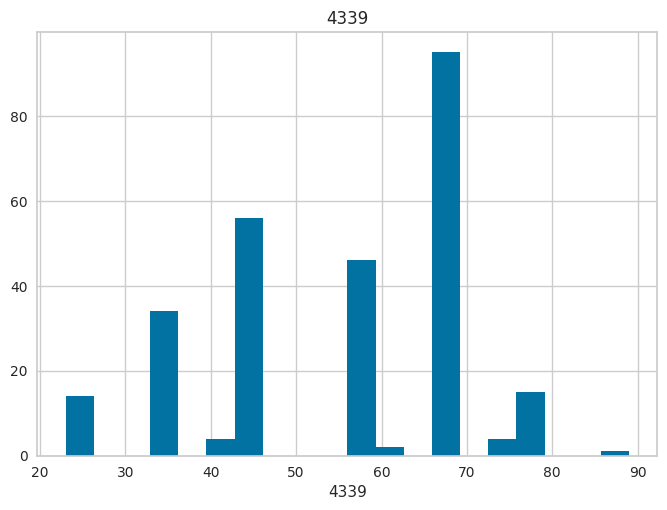

count    271.000000
mean      53.199262
std       15.161445
min       12.000000
5%        23.000000
10%       34.000000
20%       34.000000
30%       45.000000
40%       45.000000
50%       56.000000
60%       67.000000
70%       67.000000
80%       67.000000
90%       67.000000
95%       67.000000
99%       78.000000
max       78.000000
Name: 4340, dtype: float64


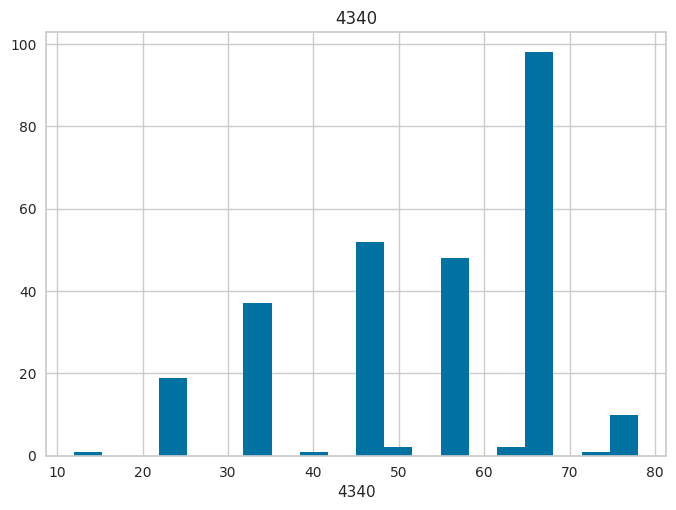

count    271.000000
mean      55.194957
std       14.794589
min       23.000000
5%        34.000000
10%       34.000000
20%       45.000000
30%       45.000000
40%       56.000000
50%       56.000000
60%       67.000000
70%       67.000000
80%       67.000000
90%       67.000000
95%       78.000000
99%       78.000000
max       89.000000
Name: 4341, dtype: float64


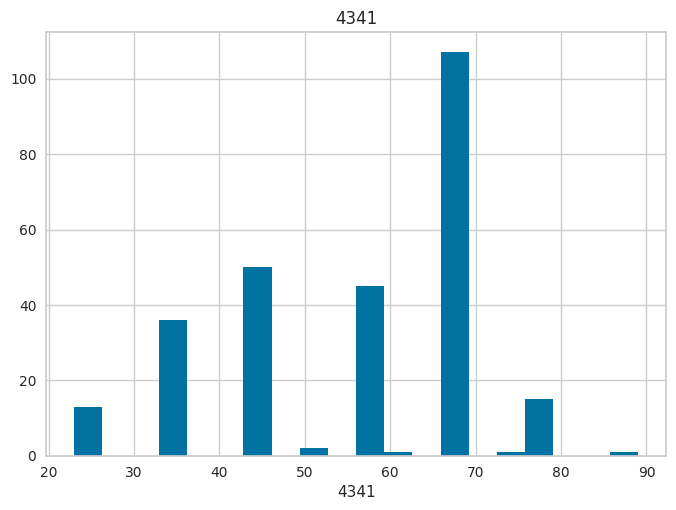

count    271.000000
mean      58.361009
std       14.718160
min       23.000000
5%        34.000000
10%       34.000000
20%       45.000000
30%       45.000000
40%       56.000000
50%       67.000000
60%       67.000000
70%       67.000000
80%       67.000000
90%       78.000000
95%       78.000000
99%       78.000000
max       89.000000
Name: 4342, dtype: float64


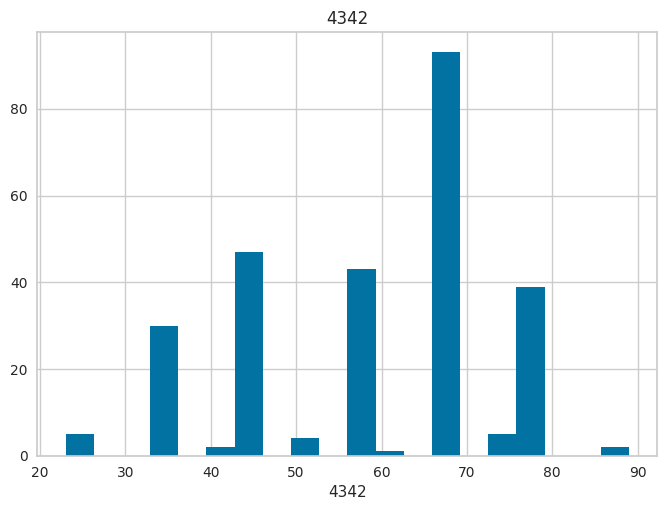

count    271.000000
mean      46.386839
std       16.790151
min       12.000000
5%        23.000000
10%       23.000000
20%       23.000000
30%       34.000000
40%       45.000000
50%       45.000000
60%       56.000000
70%       56.000000
80%       67.000000
90%       67.000000
95%       67.000000
99%       74.150000
max       89.000000
Name: 4343, dtype: float64


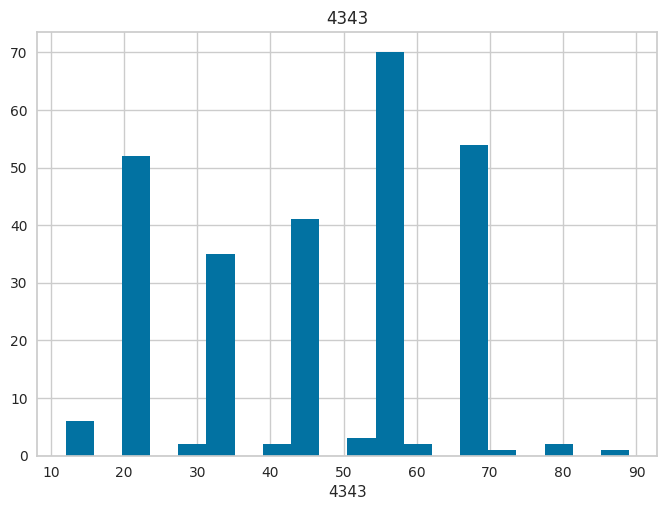

count    271.000000
mean      43.349323
std       16.909239
min       12.000000
5%        23.000000
10%       23.000000
20%       23.000000
30%       34.000000
40%       34.000000
50%       45.000000
60%       56.000000
70%       56.000000
80%       56.000000
90%       56.000000
95%       67.000000
99%       78.000000
max      100.000000
Name: 4344, dtype: float64


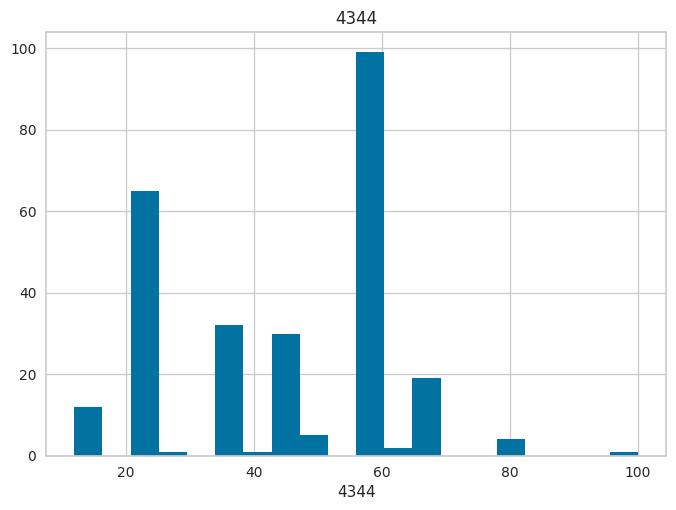

count    271.000000
mean      55.316728
std       15.768308
min       23.000000
5%        28.500000
10%       34.000000
20%       34.000000
30%       45.000000
40%       56.000000
50%       56.000000
60%       67.000000
70%       67.000000
80%       67.000000
90%       67.000000
95%       78.000000
99%       78.000000
max       83.500000
Name: 4345, dtype: float64


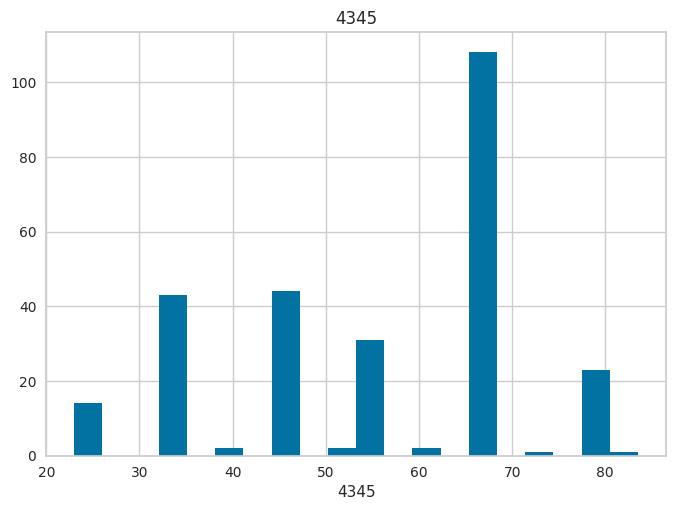

count    271.000000
mean      51.568881
std       17.591752
min       12.000000
5%        23.000000
10%       23.000000
20%       34.000000
30%       34.000000
40%       45.000000
50%       56.000000
60%       61.500000
70%       67.000000
80%       67.000000
90%       67.000000
95%       78.000000
99%       78.000000
max       89.000000
Name: 4348, dtype: float64


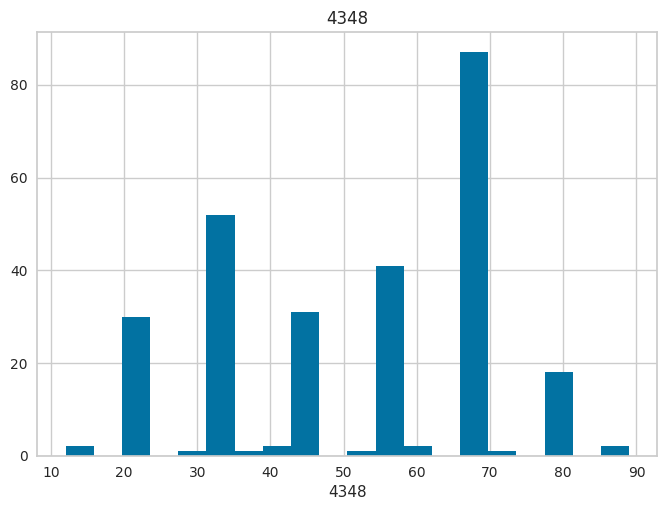

count    271.000000
mean      45.236777
std       16.095356
min       12.000000
5%        23.000000
10%       23.000000
20%       23.000000
30%       34.000000
40%       45.000000
50%       45.000000
60%       56.000000
70%       56.000000
80%       56.000000
90%       67.000000
95%       67.000000
99%       78.000000
max       89.000000
Name: 4349, dtype: float64


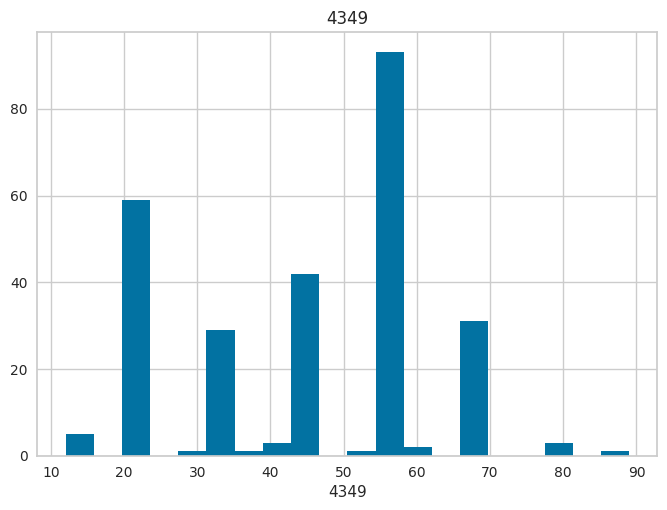

count    271.000000
mean      54.897294
std       14.302681
min       12.000000
5%        34.000000
10%       34.000000
20%       45.000000
30%       45.000000
40%       56.000000
50%       56.000000
60%       67.000000
70%       67.000000
80%       67.000000
90%       67.000000
95%       67.000000
99%       78.000000
max       78.000000
Name: 4350, dtype: float64


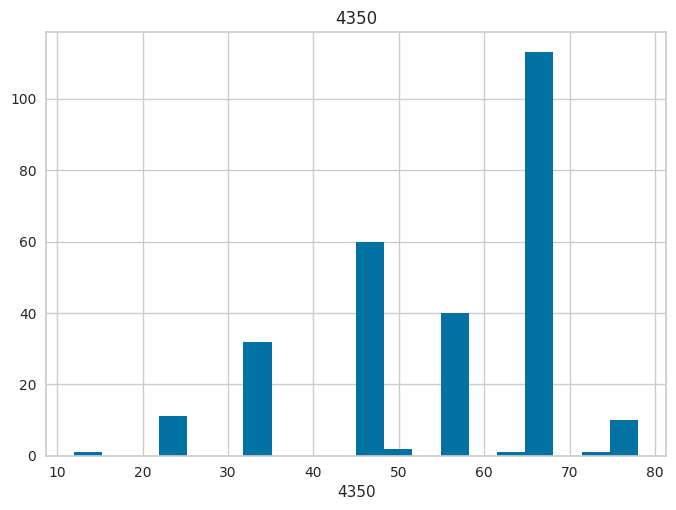

count    271.000000
mean      56.737392
std       14.344484
min       12.000000
5%        34.000000
10%       34.000000
20%       45.000000
30%       45.000000
40%       56.000000
50%       56.000000
60%       67.000000
70%       67.000000
80%       67.000000
90%       67.000000
95%       78.000000
99%       78.000000
max      100.000000
Name: 4351, dtype: float64


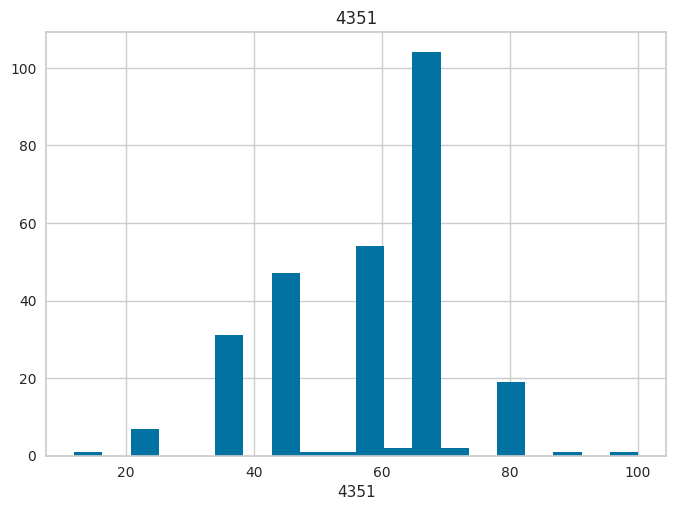

count    271.000000
mean      55.817343
std       14.243089
min       12.000000
5%        34.000000
10%       34.000000
20%       45.000000
30%       45.000000
40%       56.000000
50%       56.000000
60%       67.000000
70%       67.000000
80%       67.000000
90%       67.000000
95%       67.000000
99%       78.000000
max       78.000000
Name: 4352, dtype: float64


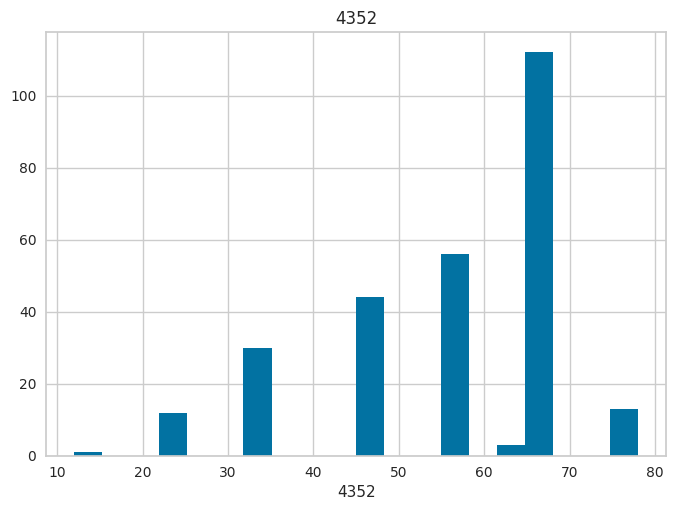

count    271.000000
mean      54.186962
std       15.776835
min       12.000000
5%        34.000000
10%       34.000000
20%       34.000000
30%       45.000000
40%       45.000000
50%       56.000000
60%       67.000000
70%       67.000000
80%       67.000000
90%       67.000000
95%       78.000000
99%       78.000000
max       78.000000
Name: 4353, dtype: float64


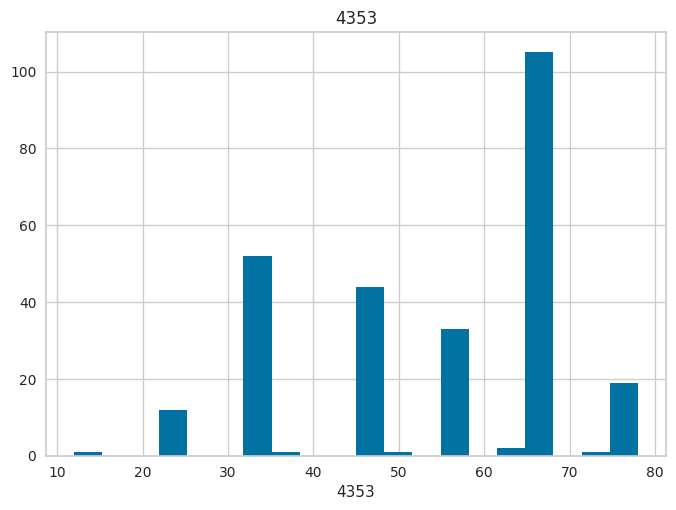

count    271.000000
mean      59.450185
std       17.652623
min       12.000000
5%        34.000000
10%       34.000000
20%       45.000000
30%       45.000000
40%       56.000000
50%       56.000000
60%       67.000000
70%       78.000000
80%       78.000000
90%       78.000000
95%       78.000000
99%       78.000000
max       78.000000
Name: 4354, dtype: float64


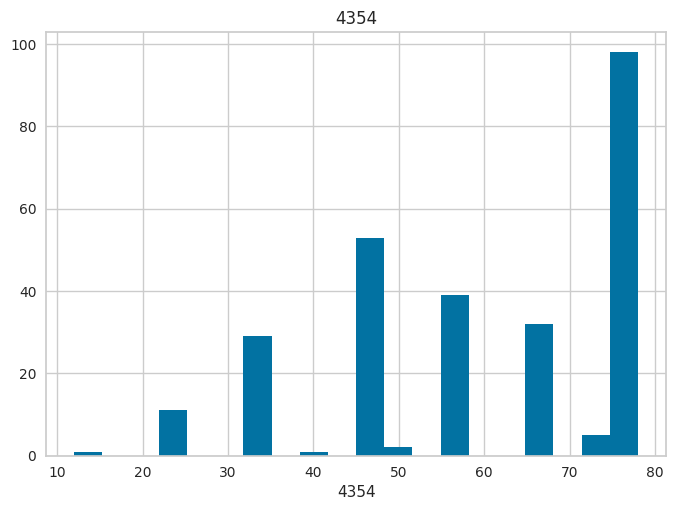

count    271.000000
mean      57.745387
std       14.677008
min       12.000000
5%        34.000000
10%       34.000000
20%       45.000000
30%       45.000000
40%       56.000000
50%       56.000000
60%       67.000000
70%       67.000000
80%       67.000000
90%       78.000000
95%       78.000000
99%       78.000000
max       89.000000
Name: 4355, dtype: float64


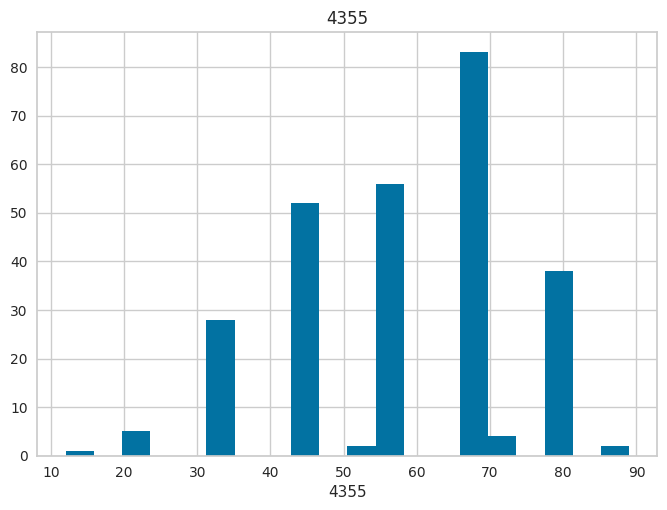

count    271.000000
mean      52.955720
std       15.378794
min       23.000000
5%        23.000000
10%       34.000000
20%       34.000000
30%       45.000000
40%       45.000000
50%       56.000000
60%       67.000000
70%       67.000000
80%       67.000000
90%       67.000000
95%       67.000000
99%       78.000000
max       78.000000
Name: 4356, dtype: float64


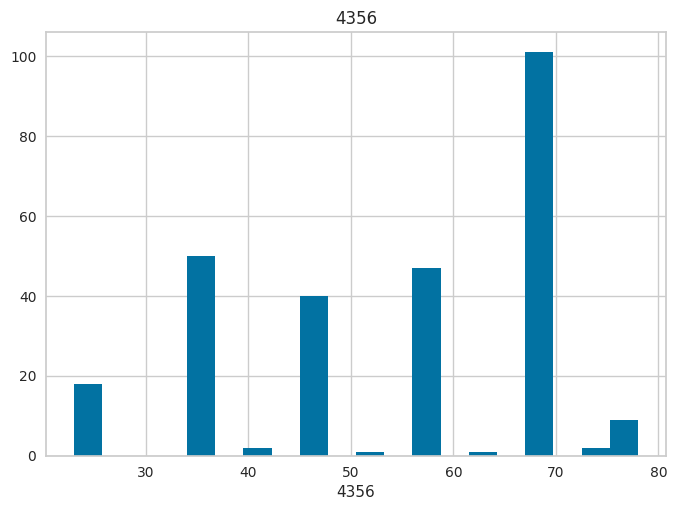

count    271.000000
mean      55.918819
std       14.450966
min       23.000000
5%        34.000000
10%       34.000000
20%       45.000000
30%       45.000000
40%       56.000000
50%       67.000000
60%       67.000000
70%       67.000000
80%       67.000000
90%       67.000000
95%       72.500000
99%       78.000000
max       78.000000
Name: 4357, dtype: float64


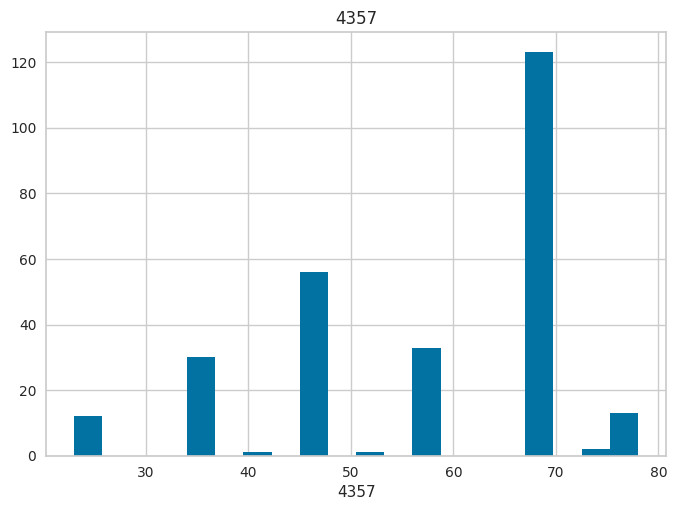

count    271.000000
mean      58.333948
std       16.391679
min        1.000000
5%        28.500000
10%       34.000000
20%       45.000000
30%       56.000000
40%       56.000000
50%       67.000000
60%       67.000000
70%       67.000000
80%       67.000000
90%       78.000000
95%       78.000000
99%       89.000000
max      100.000000
Name: 4407, dtype: float64


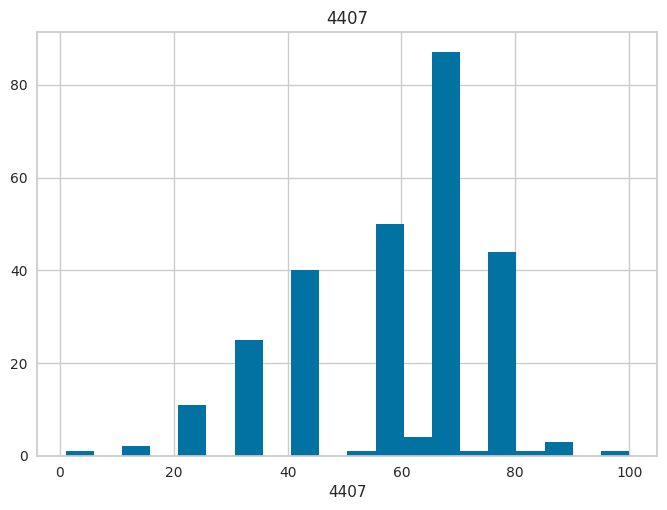

count    271.000000
mean      56.764453
std       15.334661
min       12.000000
5%        34.000000
10%       34.000000
20%       45.000000
30%       45.000000
40%       56.000000
50%       56.000000
60%       67.000000
70%       67.000000
80%       67.000000
90%       78.000000
95%       78.000000
99%       78.000000
max       89.000000
Name: 4408, dtype: float64


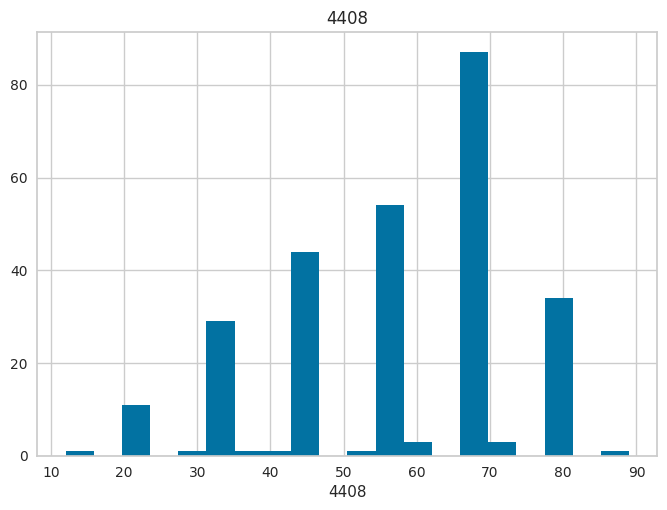

count    271.000000
mean      49.464945
std       16.217151
min       23.000000
5%        23.000000
10%       23.000000
20%       34.000000
30%       34.000000
40%       45.000000
50%       56.000000
60%       56.000000
70%       67.000000
80%       67.000000
90%       67.000000
95%       67.000000
99%       78.000000
max       78.000000
Name: 4423, dtype: float64


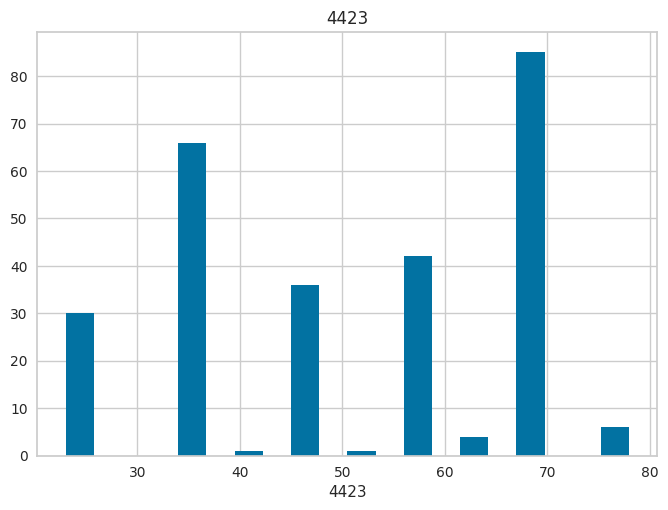

count    271.000000
mean      60.295818
std       17.028369
min       23.000000
5%        34.000000
10%       34.000000
20%       45.000000
30%       50.500000
40%       56.000000
50%       61.500000
60%       67.000000
70%       78.000000
80%       78.000000
90%       78.000000
95%       78.000000
99%       78.000000
max       89.000000
Name: 4426, dtype: float64


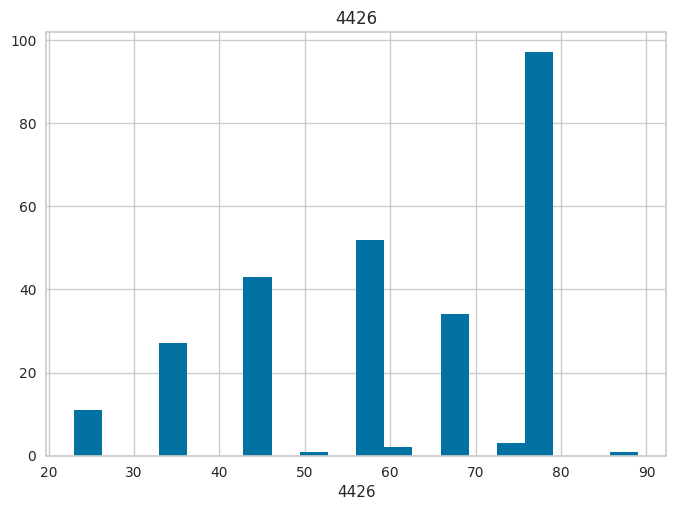

In [47]:
# Sayısal değişkenlerin özeti
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

for col in num_cols:
    num_summary(pt, col, plot=True)

In [48]:
# Target'a göre nümerik değişkenlerin özeti
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

for col in num_cols:
    target_summary_with_num(pt, "potential_label", col)

attribute_id          4322
potential_label           
average          57.142636
highlighted      63.071429


attribute_id          4323
potential_label           
average          57.867442
highlighted      62.089286


attribute_id          4324
potential_label           
average          55.343411
highlighted      59.732143


attribute_id          4325
potential_label           
average          54.558915
highlighted      66.116071


attribute_id          4326
potential_label           
average          54.209302
highlighted      64.446429


attribute_id          4327
potential_label           
average          55.735659
highlighted      59.535714


attribute_id          4328
potential_label           
average          57.432558
highlighted      61.303571


attribute_id         4329
potential_label          
average          59.24031
highlighted      60.81250


attribute_id          4330
potential_label           
average          55.872093
highlighted      60.223214


attribute_id  

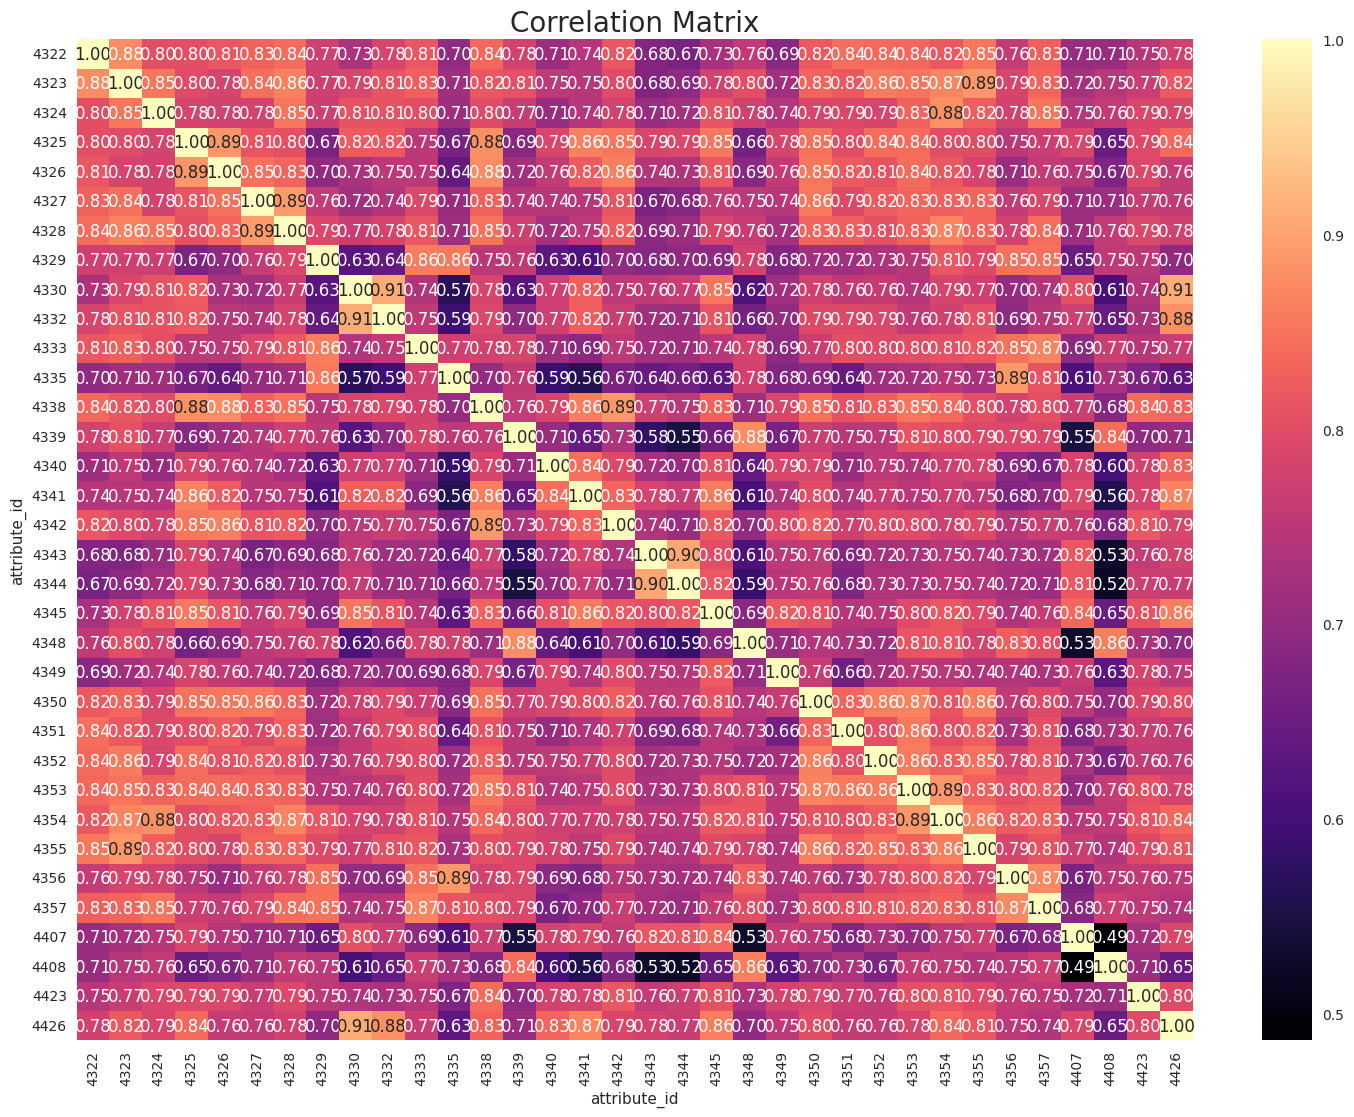

In [49]:
# Korelasyon Analizi
pt[num_cols].corr()

# Korelasyon Matrisi
f, ax = plt.subplots(figsize=[18, 13])
sns.heatmap(pt[num_cols].corr(), annot=True, fmt=".2f", ax=ax, cmap="magma")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()


In [50]:
# Feature Extraction 
pt["min"] = pt[num_cols].min(axis=1)
pt["max"] = pt[num_cols].max(axis=1)
pt["sum"] = pt[num_cols].sum(axis=1)
pt["mean"] = pt[num_cols].mean(axis=1)
pt["median"] = pt[num_cols].median(axis=1)
pt["mentality"] = pt["position_id"].apply(lambda x: "defender" if (x == 2) | (x == 3) | (x == 4) | (x == 5) else "attacker")

In [51]:
# Label Encoder fonksiyonunu kullanarak “potential_label” kategorilerini (average, highlighted) sayısal olarak ifade etmek.
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe


labelEncoderCols = ["potential_label","mentality"]

for col in labelEncoderCols:
    pt = label_encoder(pt, col)

In [52]:
pt.head()

attribute_id,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,4328,...,4407,4408,4423,4426,min,max,sum,mean,median,mentality
0,1355710,7,0,50.5,50.5,34.0,50.5,45.0,45.0,45.0,...,56.0,34.0,34.0,56.0,23.0,56.0,1436.5,42.250000,45.0,0
1,1356362,9,0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,...,67.0,67.0,56.0,78.0,56.0,78.0,2267.0,66.676471,67.0,0
2,1356375,3,0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,...,67.0,67.0,56.0,78.0,56.0,78.0,2256.0,66.352941,67.0,1
3,1356375,4,0,67.0,78.0,67.0,67.0,67.0,78.0,78.0,...,56.0,67.0,45.0,56.0,45.0,78.0,2223.0,65.382353,67.0,1
4,1356411,9,0,67.0,67.0,78.0,78.0,67.0,67.0,67.0,...,89.0,56.0,67.0,78.0,56.0,89.0,2278.0,67.000000,67.0,0


In [53]:
# Bütün “num_cols” değişkenlerindeki veriyi ölçeklendirmek için standardScaler
pt.head()
lst = ["min","max","sum","mean","median"]
num_cols = list(num_cols)

for i in lst:
    num_cols.append(i)

scaler = StandardScaler()
pt[num_cols] = scaler.fit_transform(pt[num_cols])

pt.head()

attribute_id,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,4328,...,4407,4408,4423,4426,min,max,sum,mean,median,mentality
0,1355710,7,0,-0.542606,-0.559398,-1.404764,-0.437916,-0.766602,-0.794802,-0.907351,...,-0.142650,-1.487256,-0.955381,-0.252741,-1.008124,-1.071016,-0.958691,-0.958691,-0.747463,0
1,1356362,9,0,0.595327,0.560776,0.678677,0.682837,0.722639,0.722929,0.601190,...,0.529664,0.668713,0.403717,1.041611,1.093427,0.662654,0.842668,0.842668,0.858052,0
2,1356375,3,0,0.595327,0.560776,0.678677,0.682837,0.722639,0.722929,0.601190,...,0.529664,0.668713,0.403717,1.041611,1.093427,0.662654,0.818809,0.818809,0.858052,1
3,1356375,4,0,0.595327,1.307560,0.678677,0.682837,0.722639,1.481795,1.355461,...,-0.142650,0.668713,-0.275832,-0.252741,0.392910,0.662654,0.747232,0.747232,0.858052,1
4,1356411,9,0,0.595327,0.560776,1.373158,1.430006,0.722639,0.722929,0.601190,...,1.874292,-0.049944,1.083267,1.041611,1.093427,1.529489,0.866527,0.866527,0.858052,0


# **Model**

In [54]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder

In [55]:
y = pt['potential_label']
X = pt.drop(['potential_label', 'player_id'], axis=1)

In [56]:
# Etketleri nümerik değerlere çevirme
if y.dtype == 'object':
    le = LabelEncoder()
    y = le.fit_transform(y)

In [57]:
models = [
    ('LR', LogisticRegression(max_iter=1000)),
    ('KNN', KNeighborsClassifier()),
    ('RF', RandomForestClassifier()),
    ('GBM', GradientBoostingClassifier()),
    ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
    ('LightGBM', LGBMClassifier(verbosity=-1))
]


In [58]:
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score

precision_scorer = make_scorer(precision_score, average='weighted', zero_division=0)
recall_scorer = make_scorer(recall_score, average='weighted', zero_division=0)
f1_scorer = make_scorer(f1_score, average='weighted', zero_division=0)
roc_auc_scorer = make_scorer(roc_auc_score, average='weighted', needs_proba=True, multi_class='ovr')

In [59]:
for name, model in models:
    print(name)
    scores = {
        'roc_auc': cross_val_score(model, X, y, scoring=roc_auc_scorer, cv=10).mean(),
        'f1': cross_val_score(model, X, y, scoring=f1_scorer, cv=10).mean(),
        'precision': cross_val_score(model, X, y, scoring=precision_scorer, cv=10).mean(),
        'recall': cross_val_score(model, X, y, scoring=recall_scorer, cv=10).mean(),
        'accuracy': cross_val_score(model, X, y, scoring='accuracy', cv=10).mean()
    }
    for score_name, score_value in scores.items():
        print(f"{score_name} score: {score_value:.4f}")


LR
roc_auc score: 0.8617
f1 score: 0.8498
precision score: 0.8689
recall score: 0.8669
accuracy score: 0.8669
KNN
roc_auc score: 0.7065
f1 score: 0.8004
precision score: 0.8090
recall score: 0.8413
accuracy score: 0.8413
RF
roc_auc score: 0.9003
f1 score: 0.8425
precision score: 0.9057
recall score: 0.8893
accuracy score: 0.8745
GBM
roc_auc score: 0.8623
f1 score: 0.8244
precision score: 0.8370
recall score: 0.8562
accuracy score: 0.8488
XGBoost
roc_auc score: 0.8836
f1 score: 0.8750
precision score: 0.8858
recall score: 0.8819
accuracy score: 0.8819
LightGBM
roc_auc score: 0.8934
f1 score: 0.8726
precision score: 0.8834
recall score: 0.8856
accuracy score: 0.8856


# **Hiperparametre Optimizasyonu**


In [60]:
# LIGHTGBM

import warnings
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

# Ignore LightGBM warnings
warnings.filterwarnings("ignore", category=UserWarning, module='lightgbm')

# Initialize the LGBM Classifier
lgbm_model = LGBMClassifier(random_state=46, verbosity=-1)


# Define the parameter grid
lgbm_params = {
    "learning_rate": [0.01, 0.1],
    "n_estimators": [500, 1000],
    "colsample_bytree": [0.5, 0.7]
}


# Setup GridSearchCV
lgbm_gs = GridSearchCV(
    lgbm_model,
    lgbm_params,
    cv=3,
    n_jobs=-1,
    verbose=0,  # Set verbose to 0 to reduce output during fitting
    scoring='roc_auc'
)


# Fit GridSearchCV
lgbm_gs.fit(X, y)

# Display the best parameters and best score
print("Best parameters found: ", lgbm_gs.best_params_)
print("Best ROC AUC found: ", lgbm_gs.best_score_)

Best parameters found:  {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'n_estimators': 1000}
Best ROC AUC found:  0.8885748702742773


In [71]:
# RANDOM FOREST

import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Ignore all warnings
warnings.filterwarnings("ignore")

# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(random_state=46)

# Define the parameter grid
rf_params = {
    "n_estimators": [100, 500],      # "n_estimators": [100, 500, 1000]
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}



In [72]:
# Setup GridSearchCV
rf_gs = GridSearchCV(
    rf_model,
    rf_params,
    cv=3,
    n_jobs=-1,
    verbose=0,  # Set verbose to 0 to reduce output during fitting
    scoring='roc_auc'
)



In [73]:
# Fit GridSearchCV
rf_gs.fit(X, y)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=46), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 500]},
             scoring='roc_auc')

In [74]:
# Display the best parameters and best score
print("Best parameters found: ", rf_gs.best_params_)
print("Best ROC AUC found: ", rf_gs.best_score_)

Best parameters found:  {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best ROC AUC found:  0.9097981052875626


# **Değişkenlerin Önem Düzeyini Çizmek**


In [75]:

# feature importance (LightGBM)
def plot_importance(model, features, num=len(X), save=False):

    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:num])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")

model = LGBMClassifier(verbosity=-1)
model.fit(X, y)


LGBMClassifier(verbosity=-1)

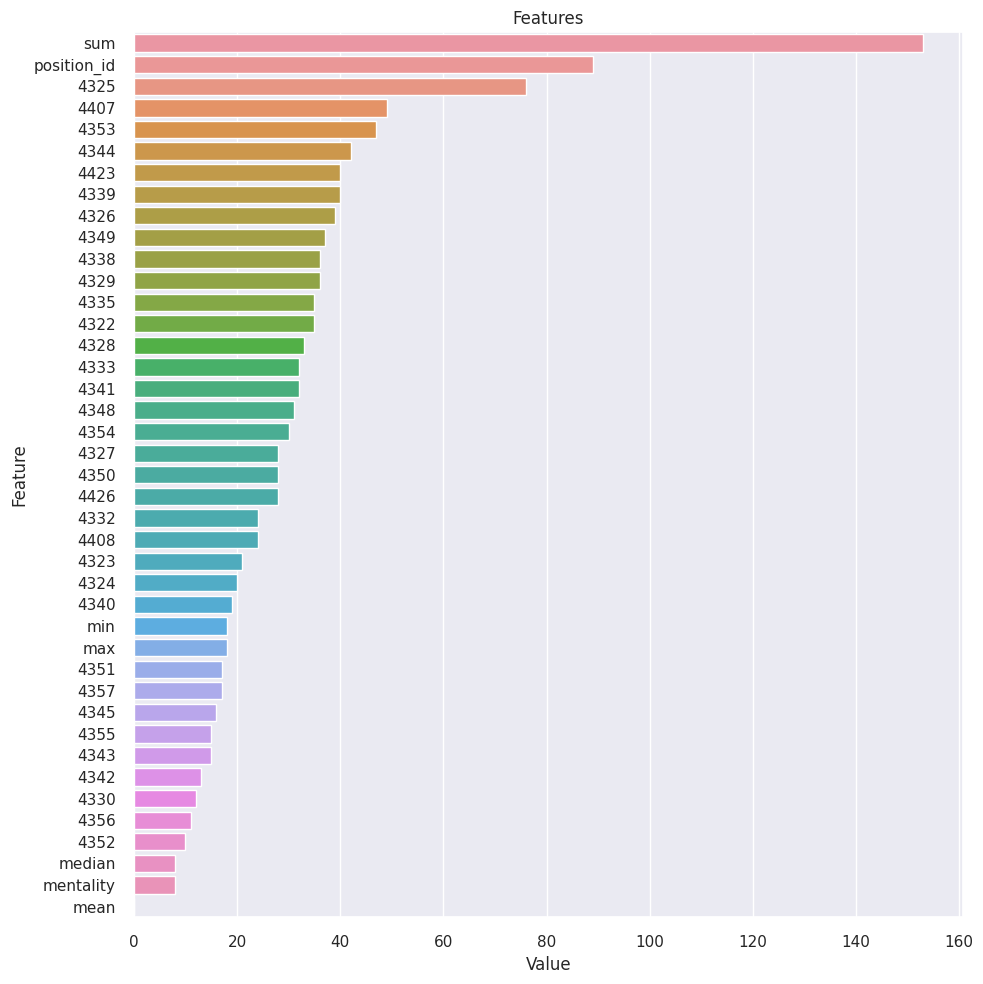

In [76]:
plot_importance(model, X)

In [77]:
# Feature importance plotting function
def plot_importance(model, features, num=len(X), save=False):
    # Get feature importances from the model
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    
    # Create the plot
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[:num])
    plt.title('Feature Importances')
    plt.tight_layout()
    plt.show()
    
    # Optionally save the plot
    if save:
        plt.savefig("feature_importances.png")

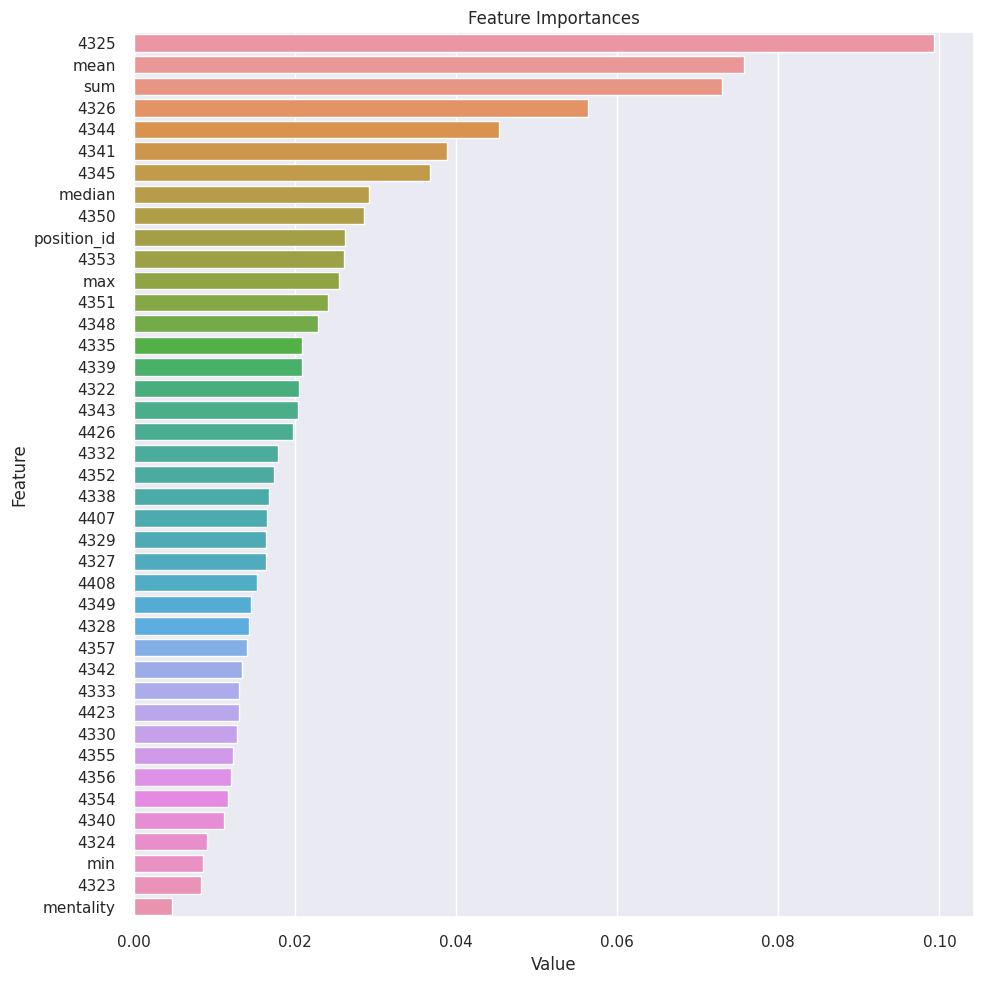

In [78]:
# Initialize and train the Random Forest model
model = RandomForestClassifier(random_state=46)
model.fit(X, y)

# Call the plotting function with the trained model and the feature set
plot_importance(model, X)